##### 10 May 2024

# Central Bank Speech EDA

Aim: visualise the Central Bank Speech Data Set using document vectors. I am particularly interested in the relationship between economic conditions and central bank speeches. When there is an economic crisis, do central bankers tend to talk about the same things? How much are they influenced by each other? Does any particular central bank stand out as being the most original?

In [1]:
from gingado.datasets import load_CB_speeches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import random
import pytz # for a list of countries

## 1. Loading Data

In [2]:
all_speeches = load_CB_speeches()
all_speeches.head()

,url,title,description,date,text,author
0,https://www.bis.org/review/r971001f.pdf,Mr. Bäckström elucidates the problems Sweden w...,Talk given by the Governor of the Swedish Risk...,1987-08-29 00:00:00,Mr. Bäckström elucidates the problems Sweden...,Urban Bäckström
1,https://www.bis.org/review/r970211c.pdf,Mr. Chen discusses monetary relations between ...,Speech by the Deputy Governor of the People's ...,1996-09-10 00:00:00,Mr. Chen discusses monetary relations between ...,Chen Yuan
2,https://www.bis.org/review/r970211b.pdf,Mr. Dai looks at the possibilities of strength...,Speech by the Governor of the People's Bank of...,1996-11-13 00:00:00,Mr. Dai looks at the possibilities of strength...,Dai Xianglong
3,https://www.bis.org/review/r970211a.pdf,Mr. Dai assesses the outlook for Hong Kong as ...,Speech by the Governor of the People's Bank of...,1996-09-30 00:00:00,Mr. Dai assesses the outlook for Hong Kong as ...,Dai Xianglong
4,https://www.bis.org/review/r970203b.pdf,Mr. Rangarajan examines the objectives of mone...,Address by the Governor of the Reserve Bank of...,1996-12-28 00:00:00,Mr. Rangarajan examines the objectives of mone...,Bimal Jalan


In [3]:
all_speeches.shape

(18827, 6)

Text(0.5, 1.0, 'Number of speeches by year')

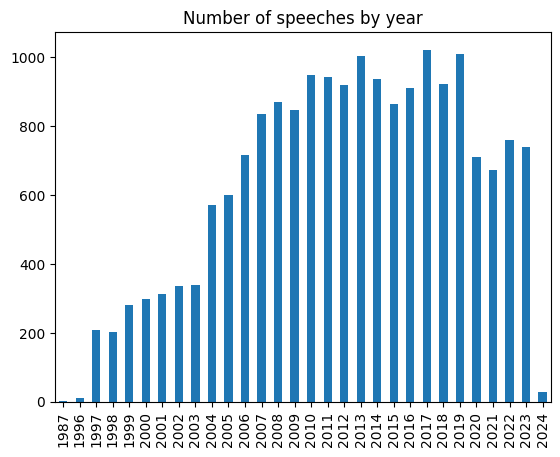

In [4]:
pd.to_datetime(all_speeches['date']).dt.year.value_counts().sort_index().plot(kind='bar')
plt.title("Number of speeches by year")

We should just keep the data from 1997 onwards.

In [5]:
pd.to_datetime(all_speeches['date']).sort_values().tail()

18824   2024-01-31 00:00:00
18825   2024-02-01 00:00:00
18821   2024-02-02 00:00:00
18823   2024-02-02 09:44:00
18799   2024-12-08 00:00:00
Name: date, dtype: datetime64[ns]

In [6]:
all_speeches.iloc[18799]

url                      https://www.bis.org/review/r240109a.htm
title          Michelle W Bowman: New year's resolutions for ...
description    Speech by Ms Michelle W Bowman, Member of the ...
date                                         2024-12-08 00:00:00
text           For release on delivery\n4:30 p.m. EST\nJanuar...
author                                         Michelle W Bowman
Name: 18799, dtype: object

This speech has been mislabelled; date should be 2023.

In [7]:
all_speeches['date'][18799] = '2023-12-08 00:00:00'

In [8]:
speeches = all_speeches.copy()
speeches['date'] = pd.to_datetime(speeches['date'])
speeches = speeches.loc[(speeches['date'].dt.year >= 1997) & (speeches['date'].dt.year <= 2023)]

In [9]:
speeches.shape

(18789, 6)

In [10]:
# it might be a good idea to reset the index here because the next model assumes that indices start
# from 0 and increase by 1
speeches = speeches.reset_index()

## 2. Creating Document Vectors

For each speech, I want to compress the content of the speech into a vector. This can be done using the `doc2vec` model from `gensim`. In order to measure the similarity between speeches, you can use the cosine distance between the vectors produced by the fitted `doc2vec` model.

I will follow the tutorial here: https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html

In our case, we don't need to have a separate training and testing set because we are doing data compression rather than prediction. 

In [11]:
# corpus is a list of documents with each document broken into tokens
corpus = []

for i in range(speeches.shape[0]):
    tokens = gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(all_speeches['text'][i]), [i])
    corpus += [tokens]

In [12]:
corpus[-1]

TaggedDocument(words=['constantinos', 'herodotou', 'speech', 'th', 'annual', 'christmas', 'gala', 'of', 'the', 'hellenic', 'bankers', 'association', 'uk', 'speech', 'by', 'mr', 'constantinos', 'herodotou', 'governor', 'of', 'the', 'central', 'bank', 'of', 'cyprus', 'at', 'the', 'th', 'annual', 'christmas', 'gala', 'of', 'the', 'hellenic', 'bankers', 'association', 'uk', 'london', 'december', 'ladies', 'and', 'gentlemen', 'esteemed', 'guests', 'would', 'like', 'to', 'thank', 'the', 'hellenic', 'bankers', 'association', 'uk', 'for', 'inviting', 'me', 'to', 'deliver', 'speech', 'at', 'tonight', 'gala', 'dinner', 'it', 'is', 'indeed', 'an', 'honour', 'to', 'address', 'this', 'distinguished', 'gathering', 'of', 'professionals', 'he', 'global', 'economic', 'environment', 'has', 'become', 'very', 'complex', 'tapestry', 'undergoing', 'unprecedented', 'shifts', 'presenting', 'significant', 'challenges', 'to', 'all', 'regions', 'including', 'the', 'euro', 'area', 'the', 'dynamics', 'are', 'compl

In [13]:
# initialise the doc2vec model

ndim = 25
# ndim should be reasonably large. I chose 25 to have roughly one dimension per year
# epochs is the number of training epochs. This just needs to be big enough to get convergence

model = gensim.models.doc2vec.Doc2Vec(vector_size=ndim, min_count=2, epochs=10)

In [14]:
model.build_vocab(corpus)

In [15]:
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

The suggested method for checking that the model works is to check whether the speeches in a randomly-selected subset are most similar to themselves or to some other speech.

In [16]:
len(model.dv)

18789

In [17]:
np.random.seed(100)
samp = np.random.choice(range(len(corpus)), 100, replace=False)
sub_corpus = [corpus[x] for x in samp]

ranks = []
second_ranks = []
                    
for doc_id in range(len(sub_corpus)):
    inferred_vector = model.infer_vector(sub_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [x for x, sim in sims].index(samp[doc_id])
    ranks.append(rank)
    second_ranks.append(sims[1])

In [18]:
import collections

counter = collections.Counter(ranks)
print(counter)

Counter({0: 98, 4: 1, 2: 1})


Most of the speeches are more similar to themself than to another speech. A further sanity check is to look at two speeches with similar document vectors and see whether they look similar.

In [19]:
# example showing two similar speeches which are identified as similar by the model
inferred_vector = model.infer_vector(corpus[1000].words)
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))

In [20]:
sims[:2]

[(1296, 0.9465479254722595), (1000, 0.944175124168396)]

In [21]:
speeches['text'][sims[0][0]][:500]

'The Rt Hon Sir Edward George GBE: What the Bank of England is trying to do\nthrough the Monetary Policy Committee in its conduct of monetary policy\nSpeech by The Rt Hon Sir Edward George GBE, Governor of the Bank of England, at the Yorkshire\nForward/Bank of England Regional Dinner, for Yorkshire and the Humber Business and Civic Leaders\nand MPs, held in Sheffield on 16 January 2001.\n* * *\nMr Chairman, I am delighted to join with you in welcoming everyone to dinner this evening here in\nSheffield, '

In [22]:
speeches['text'][sims[1][0]][:500]

'A H E M Wellink: The impact of new technologies on the implementation of\nmonetary policy\nSpeech by Dr A H E M Wellink, President of the Nederlandsche Bank, at a symposium of the Banque\nde France on "New Technologies and Monetary Policy", Paris, 30 November 2001.\n* * *\nWhen thinking about new technologies, Information and Communications Technology (ICT) is\nprobably the first thing that comes up in most people\'s mind. And, there are those who see an\nacceleration in the diffusion of ICT as being eq'

## 3. Speech Similarity

In [23]:
def simils(idx_list):
    """
    Return all similarity measures between the inferred 
    document vectors for all pairs of speeches in idx_list
    """
    if len(idx_list) == 1:
        return([])
    out=[]
    for i in range(len(idx_list))[:-1]:
        for j in range(len(idx_list))[(i+1):]:
            out += [model.dv.similarity(idx_list[i], idx_list[j])]
    return np.array(out)

In [24]:
dat = pd.to_datetime(speeches['date'])

In [25]:
f = lambda x: 0 if len(x) == 0 else np.mean(x) # mean or median makes no difference

In [26]:
def get_mean_similarity_for_period(period):
    """
    Get the mean similarity for each month, quarter or year in the date range
    period is one of 'M', 'Q' or 'Y'
    """
    period_label = dat.dt.to_period(period)
    
    out = {}
    for q in period_label.unique():
        #print(q)
        out[q] = simils( speeches[period_label == q].index )
        
    return pd.Series({k: f(v) for k, v in out.items()}).sort_index()
    

In [27]:
monthly_sim = get_mean_similarity_for_period('M')

In [28]:
quarterly_sim = get_mean_similarity_for_period('Q')

In [29]:
annual_sim = get_mean_similarity_for_period('Y')

Text(0.5, 1.0, 'Similarity of central bank speeches over time')

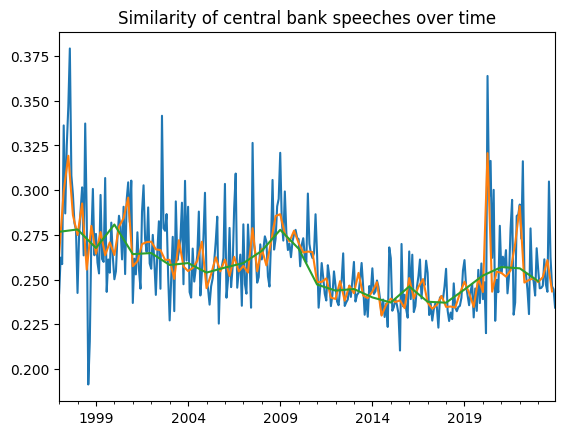

In [30]:
monthly_sim.plot()
quarterly_sim.plot()
annual_sim.plot()

plt.title("Similarity of central bank speeches over time")

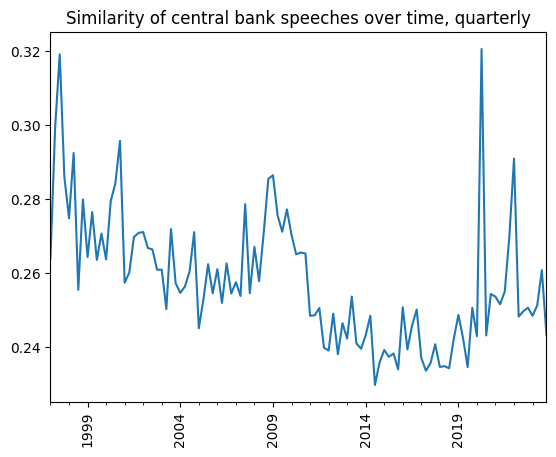

In [107]:
fig, ax = plt.subplots()
quarterly_sim.plot()
plt.title("Similarity of central bank speeches over time, quarterly");
plt.xticks(rotation=90);

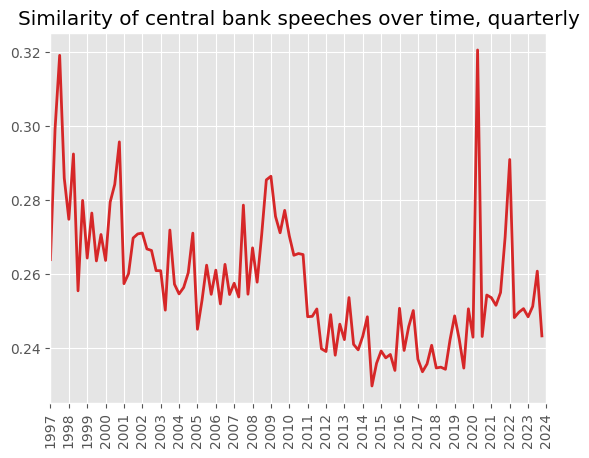

In [142]:
plt.style.use('ggplot')

fig, ax = plt.subplots()
quarterly_sim.plot(c='tab:red', linewidth=2)
plt.title("Similarity of central bank speeches over time, quarterly");
plt.xticks(rotation=90);
ax.set_xticks(range(108, 217, 4));
ax.set_xticklabels(labels = range(1997, 2025));

plt.savefig("CB_speeches/quarterly_similarity.png")

In [97]:
list([x.get_position()[0] for x in ax.get_xticklabels()])

[116, 136, 156, 176, 196]

In [32]:
quarterly_sim['2020Q2']

0.320642

In [33]:
quarterly_sim['2022Q1']

0.2910394

There are two interesting peaks in 2020Q2 when everybody was talking about covid (COVID-19 was coined on 11 February 2020) and 2022Q1 when everybody was talking about Russia invading Ukraine.

The other interesting pattern is the dissimilarity in speeches during the period of low rates from 2011-2020. I think this is because central banks did not apply policies such as QE at the same time during this period.

This leads to a rather high correlation between real rates and the similarity index, although I think it's just a coincidence in this case because of the time period covered by the data. I initially looked for a correlation between the similarity index and GDP growth, but could not find data on quarterly global GDP growth. At an annual level, there was almost zero correlation.

### Real Rates and Speech Similarity

In [34]:
# from https://fred.stlouisfed.org/series/REAINTRATREARAT1YE
real_rates = {'DATE': {0: '1997-01-01', 1: '1997-02-01', 2: '1997-03-01', 3: '1997-04-01', 4: '1997-05-01', 5: '1997-06-01', 6: '1997-07-01', 7: '1997-08-01', 8: '1997-09-01', 9: '1997-10-01', 10: '1997-11-01', 11: '1997-12-01', 12: '1998-01-01', 13: '1998-02-01', 14: '1998-03-01', 15: '1998-04-01', 16: '1998-05-01', 17: '1998-06-01', 18: '1998-07-01', 19: '1998-08-01', 20: '1998-09-01', 21: '1998-10-01', 22: '1998-11-01', 23: '1998-12-01', 24: '1999-01-01', 25: '1999-02-01', 26: '1999-03-01', 27: '1999-04-01', 28: '1999-05-01', 29: '1999-06-01', 30: '1999-07-01', 31: '1999-08-01', 32: '1999-09-01', 33: '1999-10-01', 34: '1999-11-01', 35: '1999-12-01', 36: '2000-01-01', 37: '2000-02-01', 38: '2000-03-01', 39: '2000-04-01', 40: '2000-05-01', 41: '2000-06-01', 42: '2000-07-01', 43: '2000-08-01', 44: '2000-09-01', 45: '2000-10-01', 46: '2000-11-01', 47: '2000-12-01', 48: '2001-01-01', 49: '2001-02-01', 50: '2001-03-01', 51: '2001-04-01', 52: '2001-05-01', 53: '2001-06-01', 54: '2001-07-01', 55: '2001-08-01', 56: '2001-09-01', 57: '2001-10-01', 58: '2001-11-01', 59: '2001-12-01', 60: '2002-01-01', 61: '2002-02-01', 62: '2002-03-01', 63: '2002-04-01', 64: '2002-05-01', 65: '2002-06-01', 66: '2002-07-01', 67: '2002-08-01', 68: '2002-09-01', 69: '2002-10-01', 70: '2002-11-01', 71: '2002-12-01', 72: '2003-01-01', 73: '2003-02-01', 74: '2003-03-01', 75: '2003-04-01', 76: '2003-05-01', 77: '2003-06-01', 78: '2003-07-01', 79: '2003-08-01', 80: '2003-09-01', 81: '2003-10-01', 82: '2003-11-01', 83: '2003-12-01', 84: '2004-01-01', 85: '2004-02-01', 86: '2004-03-01', 87: '2004-04-01', 88: '2004-05-01', 89: '2004-06-01', 90: '2004-07-01', 91: '2004-08-01', 92: '2004-09-01', 93: '2004-10-01', 94: '2004-11-01', 95: '2004-12-01', 96: '2005-01-01', 97: '2005-02-01', 98: '2005-03-01', 99: '2005-04-01', 100: '2005-05-01', 101: '2005-06-01', 102: '2005-07-01', 103: '2005-08-01', 104: '2005-09-01', 105: '2005-10-01', 106: '2005-11-01', 107: '2005-12-01', 108: '2006-01-01', 109: '2006-02-01', 110: '2006-03-01', 111: '2006-04-01', 112: '2006-05-01', 113: '2006-06-01', 114: '2006-07-01', 115: '2006-08-01', 116: '2006-09-01', 117: '2006-10-01', 118: '2006-11-01', 119: '2006-12-01', 120: '2007-01-01', 121: '2007-02-01', 122: '2007-03-01', 123: '2007-04-01', 124: '2007-05-01', 125: '2007-06-01', 126: '2007-07-01', 127: '2007-08-01', 128: '2007-09-01', 129: '2007-10-01', 130: '2007-11-01', 131: '2007-12-01', 132: '2008-01-01', 133: '2008-02-01', 134: '2008-03-01', 135: '2008-04-01', 136: '2008-05-01', 137: '2008-06-01', 138: '2008-07-01', 139: '2008-08-01', 140: '2008-09-01', 141: '2008-10-01', 142: '2008-11-01', 143: '2008-12-01', 144: '2009-01-01', 145: '2009-02-01', 146: '2009-03-01', 147: '2009-04-01', 148: '2009-05-01', 149: '2009-06-01', 150: '2009-07-01', 151: '2009-08-01', 152: '2009-09-01', 153: '2009-10-01', 154: '2009-11-01', 155: '2009-12-01', 156: '2010-01-01', 157: '2010-02-01', 158: '2010-03-01', 159: '2010-04-01', 160: '2010-05-01', 161: '2010-06-01', 162: '2010-07-01', 163: '2010-08-01', 164: '2010-09-01', 165: '2010-10-01', 166: '2010-11-01', 167: '2010-12-01', 168: '2011-01-01', 169: '2011-02-01', 170: '2011-03-01', 171: '2011-04-01', 172: '2011-05-01', 173: '2011-06-01', 174: '2011-07-01', 175: '2011-08-01', 176: '2011-09-01', 177: '2011-10-01', 178: '2011-11-01', 179: '2011-12-01', 180: '2012-01-01', 181: '2012-02-01', 182: '2012-03-01', 183: '2012-04-01', 184: '2012-05-01', 185: '2012-06-01', 186: '2012-07-01', 187: '2012-08-01', 188: '2012-09-01', 189: '2012-10-01', 190: '2012-11-01', 191: '2012-12-01', 192: '2013-01-01', 193: '2013-02-01', 194: '2013-03-01', 195: '2013-04-01', 196: '2013-05-01', 197: '2013-06-01', 198: '2013-07-01', 199: '2013-08-01', 200: '2013-09-01', 201: '2013-10-01', 202: '2013-11-01', 203: '2013-12-01', 204: '2014-01-01', 205: '2014-02-01', 206: '2014-03-01', 207: '2014-04-01', 208: '2014-05-01', 209: '2014-06-01', 210: '2014-07-01', 211: '2014-08-01', 212: '2014-09-01', 213: '2014-10-01', 214: '2014-11-01', 215: '2014-12-01', 216: '2015-01-01', 217: '2015-02-01', 218: '2015-03-01', 219: '2015-04-01', 220: '2015-05-01', 221: '2015-06-01', 222: '2015-07-01', 223: '2015-08-01', 224: '2015-09-01', 225: '2015-10-01', 226: '2015-11-01', 227: '2015-12-01', 228: '2016-01-01', 229: '2016-02-01', 230: '2016-03-01', 231: '2016-04-01', 232: '2016-05-01', 233: '2016-06-01', 234: '2016-07-01', 235: '2016-08-01', 236: '2016-09-01', 237: '2016-10-01', 238: '2016-11-01', 239: '2016-12-01', 240: '2017-01-01', 241: '2017-02-01', 242: '2017-03-01', 243: '2017-04-01', 244: '2017-05-01', 245: '2017-06-01', 246: '2017-07-01', 247: '2017-08-01', 248: '2017-09-01', 249: '2017-10-01', 250: '2017-11-01', 251: '2017-12-01', 252: '2018-01-01', 253: '2018-02-01', 254: '2018-03-01', 255: '2018-04-01', 256: '2018-05-01', 257: '2018-06-01', 258: '2018-07-01', 259: '2018-08-01', 260: '2018-09-01', 261: '2018-10-01', 262: '2018-11-01', 263: '2018-12-01', 264: '2019-01-01', 265: '2019-02-01', 266: '2019-03-01', 267: '2019-04-01', 268: '2019-05-01', 269: '2019-06-01', 270: '2019-07-01', 271: '2019-08-01', 272: '2019-09-01', 273: '2019-10-01', 274: '2019-11-01', 275: '2019-12-01', 276: '2020-01-01', 277: '2020-02-01', 278: '2020-03-01', 279: '2020-04-01', 280: '2020-05-01', 281: '2020-06-01', 282: '2020-07-01', 283: '2020-08-01', 284: '2020-09-01', 285: '2020-10-01', 286: '2020-11-01', 287: '2020-12-01', 288: '2021-01-01', 289: '2021-02-01', 290: '2021-03-01', 291: '2021-04-01', 292: '2021-05-01', 293: '2021-06-01', 294: '2021-07-01', 295: '2021-08-01', 296: '2021-09-01', 297: '2021-10-01', 298: '2021-11-01', 299: '2021-12-01', 300: '2022-01-01', 301: '2022-02-01', 302: '2022-03-01', 303: '2022-04-01', 304: '2022-05-01', 305: '2022-06-01', 306: '2022-07-01', 307: '2022-08-01', 308: '2022-09-01', 309: '2022-10-01', 310: '2022-11-01', 311: '2022-12-01', 312: '2023-01-01', 313: '2023-02-01', 314: '2023-03-01', 315: '2023-04-01', 316: '2023-05-01', 317: '2023-06-01', 318: '2023-07-01', 319: '2023-08-01', 320: '2023-09-01', 321: '2023-10-01', 322: '2023-11-01', 323: '2023-12-01', 324: '2024-01-01', 325: '2024-02-01', 326: '2024-03-01', 327: '2024-04-01'}, 'REAINTRATREARAT1YE': {0: 2.14983, 1: 1.9537913, 2: 2.4280658, 3: 2.5834109, 4: 2.5978435, 5: 2.7749769, 6: 2.9319809, 7: 2.6466489, 8: 2.8485872, 9: 2.3329707, 10: 2.1666538, 11: 2.8352971, 12: 2.6558134, 13: 2.5306453, 14: 2.6992495, 15: 2.7072266, 16: 2.5977446, 17: 2.8698655, 18: 2.2665315, 19: 2.3461652, 20: 2.2396001, 21: 2.1176994, 22: 2.0197782, 23: 2.3639566, 24: 1.9775485, 25: 1.9074241, 26: 2.4333445, 27: 2.5024299, 28: 2.1618375, 29: 3.4490384, 30: 2.5459072, 31: 2.6316378, 32: 2.7154129, 33: 2.2576701, 34: 2.1669458, 35: 1.844043, 36: 2.6534989, 37: 2.6396214, 38: 2.65931, 39: 2.895699, 40: 2.788998, 41: 1.9782496, 42: 3.3533364, 43: 3.2388842, 44: 3.0037547, 45: 3.0465728, 46: 2.7562754, 47: 2.3188388, 48: 3.1255613, 49: 2.8342522, 50: 3.6173011, 51: 2.3977764, 52: 1.8632221, 53: 1.4453971, 54: 1.692817, 55: 1.5937315, 56: 0.25169635, 57: 1.0254736, 58: 1.0557458, 59: -0.19812037, 60: 0.7873759, 61: 0.85551172, 62: 1.0803957, 63: 0.53216094, 64: 0.1082215, 65: 0.44413012, 66: 0.25558851, 67: 0.18227988, 68: -0.01541029, 69: -0.19993985, 70: -0.27816716, 71: -0.06171805, 72: -0.19006412, 73: -0.18728049, 74: -0.17478652, 75: -0.10768997, 76: 0.08037008, 77: -1.2220189, 78: -0.09244847, 79: 0.09684109, 80: 0.05638458, 81: -0.19647062, 82: -0.16354861, 83: -0.60214837, 84: -0.13765171, 85: -0.40138788, 86: -0.06433799, 87: -0.41226559, 88: -0.50688531, 89: -0.99233744, 90: -0.44661319, 91: -0.49146606, 92: -1.3323849, 93: -0.21069296, 94: -0.0437757, 95: 1.1770015, 96: 0.34105223, 97: 0.53033359, 98: 0.58317037, 99: 0.48126552, 100: 0.66765132, 101: 0.82656544, 102: 1.091236, 103: 1.271347, 104: 1.9752641, 105: 1.1813055, 106: 1.2722723, 107: 0.86637481, 108: 2.0226777, 109: 2.1201459, 110: 3.246409, 111: 2.0911709, 112: 2.2952525, 113: 2.3841245, 114: 2.1645871, 115: 2.153258, 116: 2.7697787, 117: 2.8277534, 118: 3.3534887, 119: 3.4453264, 120: 2.294261, 121: 2.4827834, 122: 2.0810997, 123: 2.0617647, 124: 1.4530358, 125: 1.0868654, 126: 1.9074841, 127: 2.1308389, 128: 1.8061964, 129: 1.7092106, 130: 2.1927741, 131: 1.4931414, 132: 1.1205579, 133: 0.29817483, 134: 0.63290718, 135: 0.06574427, 136: -0.38171377, 137: -0.36084469, 138: -0.81728214, 139: -1.4738705, 140: -1.016002, 141: 1.1947825, 142: 2.7838687, 143: 2.5489929, 144: 2.0270346, 145: 2.0787439, 146: 3.2452505, 147: 0.06938378, 148: 0.06749577, 149: 0.48903207, 150: -0.10306189, 151: -0.96508483, 152: -1.8867063, 153: -0.80983562, 154: -1.0056144, 155: -1.2196567, 156: -0.81215137, 157: -1.0673252, 158: -1.6183063, 159: -0.44425119, 160: -0.50458009, 161: -0.38416424, 162: -0.07004565, 163: -0.68622794, 164: -0.13733499, 165: -1.0022379, 166: -1.1654831, 167: -0.93692711, 168: -1.1089811, 169: -1.373086, 170: -1.5335463, 171: -1.4687821, 172: -2.1228984, 173: -2.0438566, 174: -2.5660386, 175: -1.2961883, 176: -0.74655287, 177: -1.5956564, 178: -1.6411563, 179: -1.9541367, 180: -1.5949972, 181: -1.662549, 182: -1.3275764, 183: -1.873893, 184: -1.2500145, 185: -0.35978255, 186: -1.2109077, 187: -1.1657948, 188: -2.1246725, 189: -1.6792467, 190: -1.5182398, 191: -2.4897123, 192: -1.1161637, 193: -0.94603683, 194: 0.4888702, 195: -0.77068502, 196: -0.51296752, 197: -0.68342236, 198: -0.16887147, 199: -1.573045, 200: -1.3560346, 201: -1.0756253, 202: -1.0172945, 203: -1.9145737, 204: -1.3452525, 205: -1.4015135, 206: -0.87407667, 207: -1.3215843, 208: -1.5203879, 209: -1.1902893, 210: -1.7835622, 211: -1.3198803, 212: -1.9720523, 213: -1.1100793, 214: -0.34990728, 215: -2.5032918, 216: 1.1239749, 217: 1.5423693, 218: 0.91614976, 219: -0.83404213, 220: -0.98806997, 221: -1.18205955, 222: -1.264703, 223: -1.3028805, 224: -1.7461364, 225: -0.84535881, 226: -0.73988133, 227: -0.72996474, 228: -0.8721907, 229: -0.21080726, 230: 0.20280334, 231: -1.18731654, 232: -1.1736869, 233: -0.55190959, 234: -1.50103723, 235: -1.41616467, 236: -2.20417488, 237: -1.65360405, 238: -1.88065568, 239: -2.25275783, 240: -1.37086914, 241: -1.18188446, 242: -0.15871639, 243: -0.56455297, 244: -0.40602435, 245: 0.68431521, 246: -0.44468298, 247: -0.37064119, 248: -1.01705756, 249: -0.83785636, 250: -0.98384247, 251: -2.81708626, 252: -0.7772657, 253: -0.83055203, 254: 1.34333197, 255: 0.77551332, 256: 0.43880137, 257: 0.75638472, 258: -0.1297353, 259: -0.11489998, 260: -0.68478285, 261: -0.1819306, 262: 0.11522289, 263: 0.48206827, 264: 0.59518209, 265: 0.56831863, 266: 5.6999287, 267: 3.11685814, 268: 1.86934498, 269: 1.84771863, 270: 1.0521675, 271: 0.64538988, 272: 0.28409933, 273: -0.04052344, 274: -0.22348679, 275: -0.28927221, 276: -0.59602385, 277: -0.54217106, 278: 3.35421645, 279: 3.23944367, 280: 2.87932085, 281: 1.41774102, 282: -0.74405804, 283: -1.24438508, 284: -1.31528359, 285: -1.20327548, 286: -1.34746957, 287: -1.83847259, 288: -1.61108806, 289: -2.03085035, 290: -1.50202356, 291: -1.52838991, 292: -1.70438715, 293: -1.92139542, 294: -2.01792543, 295: -3.20561303, 296: -3.47182721, 297: -1.84043425, 298: -2.60001778, 299: -2.92875407, 300: -2.23245881, 301: -2.64867235, 302: -2.9980438, 303: -3.28578549, 304: -3.25642212, 305: -3.96642481, 306: -1.40330475, 307: -1.47068045, 308: -2.58910241, 309: 0.02713679, 310: 0.2496431, 311: 0.8279474, 312: 1.35596652, 313: 1.43385141, 314: 2.60005624, 315: 1.24802557, 316: 1.14790584, 317: 8.00560278, 318: 5.10470969, 319: 4.30642606, 320: 3.32253749, 321: 3.1828759, 322: 2.78276472, 323: 1.62638336, 324: 2.50688884, 325: 2.39577672, 326: 3.03562019, 327: 2.01184596}}

In [35]:
rr = pd.DataFrame(real_rates)
rr['DATE'] = pd.to_datetime(rr['DATE'])
rr_q = rr.groupby(rr['DATE'].dt.to_period('Q'))['REAINTRATREARAT1YE'].mean()

In [36]:
rr_q.corr(quarterly_sim)

0.45509838383884177

### Global GDP growth and Speech Similarity

In [37]:
# from World Bank
global_gdp_growth = pd.Series({1996: 3.57819134153574, 1997: 3.92103478697763, 1998: 2.85676209531884, 1999: 3.55473318342068, 2000: 4.52903920098606, 2001: 2.02749819443821, 2002: 2.29871991199965, 2003: 3.10560021395519, 2004: 4.47149414152585, 2005: 4.00667776372401, 2006: 4.44015319931424, 2007: 4.37542905121782, 2008: 2.06370094052765, 2009: -1.3646809340806, 2010: 4.52780699270087, 2011: 3.31697730294009, 2012: 2.69770422222682, 2013: 2.799701732347, 2014: 3.06700829835658, 2015: 3.06959305611582, 2016: 2.78675707906703, 2017: 3.39605661618111, 2018: 3.27628312021918, 2019: 2.59078545726159, 2020: -3.05780976669379, 2021: 6.22859396417259, 2022: 3.0893791250156})

In [38]:
global_gdp_growth.index = global_gdp_growth.index.astype(str)

In [39]:
annual_sim.index = annual_sim.index.astype(str)

In [40]:
pd.Series(global_gdp_growth).corr(annual_sim)

-0.020086444945065726

## 4. Adding Country Labels

I would like to look at differences between the central banks of different countries. Unfortunately it is not so easy to extract the countries from the metadata (this would be a perfect task for an LLM!) I tried `geograpy` but could not install it. I also tried `GeoText` but it gave a lot of false results, for example the word "manufacturing" is identified as "Turkey" because it contains the string "tur".

In the end, it was easier to do it myself. The speeches can be roughly labelled based on the idea that the country that gets the most mentions in a speech is usually the one whose central banker gave the speech. This is not always the case, but it's good enough for exploratory analysis.

In [41]:
countries = list(pytz.country_names.values())
# Need to add some countries by their most common name in the speeches
countries += ['United Kingdom', 'UK', 'US', 'USA', 'EU']

In [42]:
def get_countries_in_text(text):
    d = {}
    for country in countries:
        if str(country).lower() in str(text).lower():
            d[country] = str(text).count(country)
    return d

In [43]:
country_guesses = speeches['author'].copy()

for i in speeches.index:
    d = get_countries_in_text(speeches['text'][i])
    #print(d)
    if len(d) > 0:
        country_guesses[i] = max(d, key=d.get)

In [44]:
country_guesses.value_counts()[:20]

US               2247
EU               1282
United States    1234
Japan             981
India             917
UK                714
Germany           618
Canada            595
Australia         548
Malaysia          504
Philippines       453
China             432
Sweden            407
France            402
Italy             386
South Africa      359
Spain             347
Ireland           333
Switzerland       310
Singapore         302
Name: author, dtype: int64

In [45]:
# some labels are repeated
country_guesses[country_guesses == "United States"] = "US"
country_guesses[country_guesses == "United Kingdom"] = "UK"

## 5. Similarity between countries

There are many possible approaches to measuring the similarity between countries. Here, I choose to calculate an average speech for each country and then find the distances between these average speeches. An alternative approach would be to take a country-by-country sample.

We just look at countries with a reasonable number of speeches in the data set.

In [46]:
common_countries = country_guesses.value_counts()[country_guesses.value_counts() >= 50].index

In [47]:
common_countries

Index(['US', 'EU', 'Japan', 'India', 'UK', 'Germany', 'Canada', 'Australia',
       'Malaysia', 'Philippines', 'China', 'Sweden', 'France', 'Italy',
       'South Africa', 'Spain', 'Ireland', 'Switzerland', 'Singapore',
       'Albania', 'Hong Kong', 'Norway', 'Greece', 'Thailand', 'New Zealand',
       'Kenya', 'Mauritius', 'Zambia', 'Uganda', 'Netherlands', 'Fiji',
       'Chile', 'Russia', 'Serbia', 'Pakistan', 'Finland', 'Israel', 'Mexico',
       'Barbados', 'Denmark', 'Turkey', 'Iceland', 'Portugal', 'Mali',
       'Indonesia', 'Austria', 'Ukraine', 'Sri Lanka', 'Romania', 'Malta',
       'Ghana', 'Guinea', 'Bahrain', 'Bulgaria', 'Argentina'],
      dtype='object')

We need to convert each speech into a vector. Unfortunately, this seems to be stochastic, so the model will not produce the same vector every time, even if the random number generator is seeded.

In [48]:
inferred_vectors = np.empty(shape=(len(corpus), ndim))
for i in range(len(corpus)):
    inferred_vectors[i, ] = model.infer_vector(corpus[i].words)

In [49]:
model.infer_vector(corpus[0].words)

array([-0.68686926, -2.6307495 , -3.9888136 ,  0.01718775,  1.7281115 ,
        1.3935143 , -1.8249713 ,  0.6105629 , -2.6983268 ,  3.1537287 ,
       -2.6287203 ,  1.3811401 ,  2.634758  ,  2.0419946 , -1.7407146 ,
       -0.2520983 , -0.19446577, -0.00519735,  0.13773401, -0.32063857,
       -0.15334694,  1.8611761 ,  1.2250328 ,  0.5409451 ,  2.9035418 ],
      dtype=float32)

In [50]:
pd.DataFrame(inferred_vectors)
# check that this isn't being changed by the cell below?
# something is changing it

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.726812,-2.753734,-3.829720,-0.148317,1.766732,1.372060,-1.881633,0.673234,-2.725822,3.179619,...,-0.278667,-0.153871,0.088865,0.237472,-0.321704,-0.227273,1.826929,1.294405,0.519944,2.721739
1,-3.164304,-0.437859,-2.378716,-1.351701,-0.399772,2.012803,2.358006,-0.843087,-0.012019,-1.060072,...,2.872050,1.542225,-0.692325,-0.379262,0.374069,-1.603375,1.335348,0.343948,1.274918,-0.042044
2,-2.474999,1.130577,-2.730608,-2.331071,-0.459550,0.543049,2.532173,-0.411363,0.686970,-1.112593,...,1.758512,1.334225,-1.060565,-0.614498,-0.570775,-1.172543,0.242348,1.349377,0.673243,-0.220777
3,-2.800829,0.190881,-2.432526,-0.752761,0.067794,1.305459,2.116350,-0.398783,-0.062031,-2.011877,...,1.795394,1.297883,-1.272450,-0.125315,0.142018,-0.661252,1.350157,-0.108571,0.860568,-1.409234
4,-1.602520,-1.885277,0.926242,0.267622,1.427924,0.335049,-2.414187,-0.459409,-0.252995,1.627749,...,0.008379,-0.695875,-2.032271,-0.556749,-0.416580,1.937450,1.872033,-1.106542,3.267857,0.456397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18784,-1.705181,1.151868,-1.211552,-1.498579,-1.137826,1.706012,2.365211,-1.826270,1.201014,-1.347797,...,0.427697,-0.843157,-0.375595,-1.960998,-0.632120,-0.231225,2.253417,0.568916,0.143346,1.856208
18785,1.837333,2.792459,-1.966343,-1.633509,0.054279,-0.277894,-2.196355,-0.743075,-3.378850,-0.069084,...,-3.939398,-0.968679,1.154098,-1.402350,-0.025226,3.879269,0.809515,-1.394996,0.834085,-2.603415
18786,-1.868272,1.881693,-0.030444,-1.868371,-0.479757,1.317488,3.702231,-0.329287,-0.126321,-0.735690,...,1.088539,-1.130881,0.986012,-1.556022,-0.851469,0.288221,2.122311,1.943195,0.858681,0.228222
18787,-0.315281,0.426644,-1.533466,0.034903,0.677648,1.257005,2.294607,-0.111247,-1.463781,0.511739,...,-1.090516,1.027880,0.398369,-1.595150,-1.456847,1.143832,-3.040802,-0.018044,1.396491,-0.477314


In [51]:
mean_speech_by_country = pd.DataFrame(inferred_vectors).groupby(country_guesses).apply(np.mean, axis=0)

In [52]:
mean_speech_by_country.loc[mean_speech_by_country.index.isin(common_countries),:]

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
author,,,,,,,,,,,,,,,,,,,,,
Albania,-0.676306,-0.402536,-1.180648,-0.923998,0.227913,1.066191,0.489340,0.416477,-0.842238,-0.106438,...,-0.553355,0.615154,-0.495479,-1.326370,-0.698696,0.653296,0.330369,0.609373,1.425941,0.958068
Argentina,-0.853579,-0.654397,-1.304001,-0.544494,0.254096,1.019304,0.529033,0.479035,-0.654423,-0.347471,...,-0.084935,0.230557,-0.661104,-1.071176,-0.398808,0.554874,0.811036,0.645293,1.641337,1.111230
Australia,-0.666967,-0.513420,-1.013772,-0.832717,0.266154,1.070794,0.416769,0.377982,-1.074177,-0.045834,...,-0.699405,0.545592,-0.494652,-1.202927,-0.606191,0.648969,0.461149,0.445803,1.451469,1.099023
Austria,-0.356412,-0.492067,-0.865402,-0.873541,0.065694,1.218018,0.314201,0.452608,-1.239006,-0.062102,...,-0.808245,0.206514,-0.707912,-1.457784,-0.260758,0.823819,0.606250,0.251911,1.241038,1.173245
Bahrain,-0.882299,-0.692971,-1.400780,-0.521654,0.296168,0.981528,0.650772,0.665103,-0.822336,-0.271131,...,0.050183,0.645106,-0.430378,-0.975702,-0.983423,0.486895,0.519718,0.497709,1.536918,1.140275
Barbados,-0.606341,-0.347864,-1.255646,-0.715327,0.171947,1.065627,0.387462,0.497854,-1.085802,-0.000454,...,-0.593465,0.710206,-0.510912,-1.154466,-0.694572,0.552545,0.401928,0.547737,1.428707,0.961467
Bulgaria,-0.650251,-0.275628,-1.174745,-0.848132,0.203735,1.060850,0.616155,0.166116,-1.006415,-0.127719,...,-0.617267,0.538499,-0.033381,-1.322211,-0.842151,0.870805,0.403698,0.526644,1.273446,0.869036
Canada,-0.615641,-0.463555,-1.116452,-0.860982,0.201557,1.021703,0.294274,0.393674,-1.015906,-0.047210,...,-0.666179,0.507492,-0.540674,-1.238061,-0.569697,0.640654,0.504699,0.536952,1.464615,1.125716
Chile,-0.671164,-0.456807,-1.025973,-0.682307,-0.002964,1.159294,0.420699,0.413797,-1.087510,0.011767,...,-0.890384,0.437599,-0.584023,-1.262786,-0.596867,0.634196,0.233812,0.449225,1.414010,1.185871


In [53]:
cc = mean_speech_by_country.loc[mean_speech_by_country.index.isin(common_countries),:]

In [54]:
avg_sim = {}

for x in cc.index:
    simx = 0
    for y in cc.index:
        if y != x:
            simx += np.dot(cc.loc[x, :], cc.loc[y, :]) / np.linalg.norm(cc.loc[x, :]) / np.linalg.norm(cc.loc[y, :])
    simx /= (len(common_countries) - 1)
    avg_sim[x] = simx

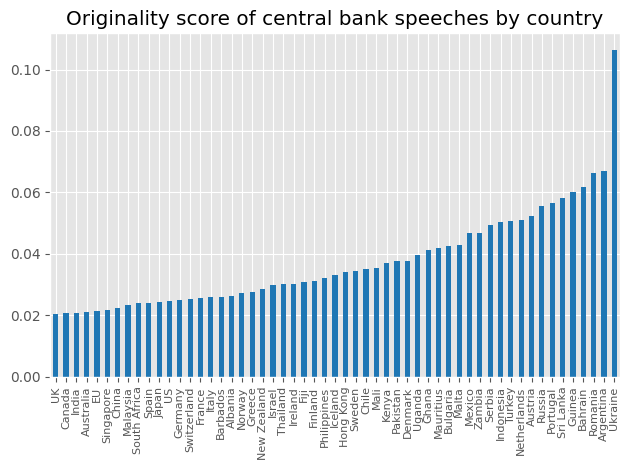

In [140]:
(1 - pd.Series(avg_sim)).sort_values().plot(kind='bar', color='tab:blue')
#plt.ylim(0.9, 1);

plt.title("Originality score of central bank speeches by country");
plt.xticks(fontsize = 8);

plt.tight_layout()
plt.savefig("CB_speeches/speech_originality.png")

An alternative approach: for each country, compare, say, 100 speeches from that country to 100 random speeches from other countries and calculate the average distance? But this turns out to be too random, and plots look flat.

## 6. Plotting typical speeches for G7 countries

In [56]:
G7 = ['US', 'UK', 'Canada', 'Germany', 'France', 'Italy', 'Japan']

In [57]:
rows_by_country = {}

for x in G7:
    sample_rows = np.where(country_guesses == x)[0]
    rows_by_country[x] = sample_rows

In [58]:
sample_vectors = {}

for x in rows_by_country.keys():
    sample_vectors[x] = np.empty(shape=(len(rows_by_country[x]), 25))
    for i in range(len(rows_by_country[x])):
        sample_vectors[x][i, ] = inferred_vectors[rows_by_country[x][i], :].copy()
    sample_vectors[x] = pd.DataFrame(sample_vectors[x])

In [59]:
x_df = pd.concat(sample_vectors)

In [60]:
x_df

0         1         2         3         4         5   \
US    0   -0.726812 -2.753734 -3.829720 -0.148317  1.766732  1.372060   
      1   -0.062932  1.379043 -2.868138 -3.029330  0.598298 -1.294366   
      2   -0.679995  1.184884 -1.212012 -0.560129 -1.011183  1.021106   
      3   -2.300534 -1.455281 -0.562921 -0.217984  0.596300  1.064345   
      4   -1.335670  0.129091 -1.028971 -0.632011 -1.455367 -0.241798   
...             ...       ...       ...       ...       ...       ...   
Japan 976 -0.113469  2.133439  0.443863 -0.816068 -2.047004  2.855190   
      977  1.507784  0.972460  0.021162 -3.204305 -0.291298 -0.869553   
      978  0.899602 -2.303564 -1.344821  0.363683  0.767386  1.817866   
      979  1.008651 -0.783352 -2.794230  0.292917  0.438782  0.737724   
      980 -1.839127 -2.013056 -0.700606 -1.337969 -1.387796  3.040730   

                 6         7         8         9   ...        15        16  \
US    0   -1.881633  0.673234 -2.725822  3.179619  ... -0.278667 -0.153871   
      1   -1.339118  1.523911 -1.072598  0.118974  ... -1.655639 -2.848694   
      2    1.323005  0.606623  0.003354  1.093649  ... -1.859678 -1.242143   
      3    0.239447 -1.296723 -1.015175 -0.645947  ...  2.075961  0.981358   
      4    0.272499 -3.060683  0.653240 -3.316093  ...  0.682575  0.868885   
...             ...       ...       ...       ...  ...       ...       ...   
Japan 976  0.570900  1.177004 -1.514136  0.340776  ... -2.038245 -0.135214   
      977 -0.604129 -0.566014 -4.037282  0.947963  ... -2.615183 -1.676642   
      978  0.330007  0.910945 -0.518129 -1.747044  ... -1.760973  0.238633   
      979  0.028501  0.143290 -0.026780 -0.901272  ... -1.976153  1.411626   
      980  2.576129 -1.247144 -1.964888  2.271132  ... -3.568987  4.691307   

                 17        18        19        20        21        22  \
US    0    0.088865  0.237472 -0.321704 -0.227273  1.826929  1.294405   
      1   -1.925353 -2.621450 -2.439651  1.050284 -1.553373  2.866223   
      2    0.660054  1.060572  0.607100  0.333933  1.309683  1.138046   
      3   -0.426183  1.887202  1.244714  0.059670  5.104399 -0.820123   
      4   -5.785191  0.009272  0.985530 -1.592179  2.839749  0.572712   
...             ...       ...       ...       ...       ...       ...   
Japan 976 -3.012763 -2.071256  0.880273  0.502235 -0.951551  0.601151   
      977 -1.668704 -3.091570  0.477835  2.225670 -0.549374 -0.697697   
      978 -1.974607 -0.429629 -1.737943  2.032667  0.322415  0.500508   
      979 -1.695928 -0.644645 -1.640705  0.526329 -0.498728  0.768999   
      980 -0.049576 -0.885379  0.221941 -2.742567 -0.044547  0.995243   

                 23        24  
US    0    0.519944  2.721739  
      1    1.124259  0.232741  
      2    2.766827  0.227906  
      3    4.321712  1.489204  
      4    3.045822  3.785099  
...             ...       ...  
Japan 976 -1.189857  1.614880  
      977 -0.906810 -1.399573  
      978  2.086977  3.518804  
      979  1.082204  0.829781  
      980  1.348349  2.805595  

[7213 rows x 25 columns]

In [61]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x_df)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

In [62]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [63]:
principalDf

,PC1,PC2
0,-1.769659,0.805932
1,-0.975401,-3.675869
2,-0.838524,-0.185804
3,-4.050642,3.846059
4,-1.898288,3.010910
...,...,...
7208,2.558285,-1.724894
7209,0.430933,-4.940290
7210,0.341996,1.231813
7211,0.439765,-0.169916


In [64]:
principalDf.index = x_df.index

In [108]:
# sample 200 rows from each country, or else the US will dominate the plot
samp_df = []
country_idx = np.array([a[0] for a in principalDf.index])

for x in G7:
    samp_df += list( np.random.choice(np.where(country_idx == x)[0], 200, replace=False) )
    

In [112]:
principalDf.iloc[samp_df, :]

PC1       PC2
US    789   1.130356 -0.207389
      114  -0.609875 -1.938363
      3379  0.081815  0.481770
      1994 -1.183766  1.096144
      745  -4.221565 -2.359276
...              ...       ...
Japan 74   -0.148136  2.111070
      79   -2.961552 -1.659381
      137   0.589332 -4.420828
      437   2.334887 -0.652182
      633  -1.319149 -0.833795

[1400 rows x 2 columns]

In [113]:
plot_df = principalDf.iloc[samp_df, :]

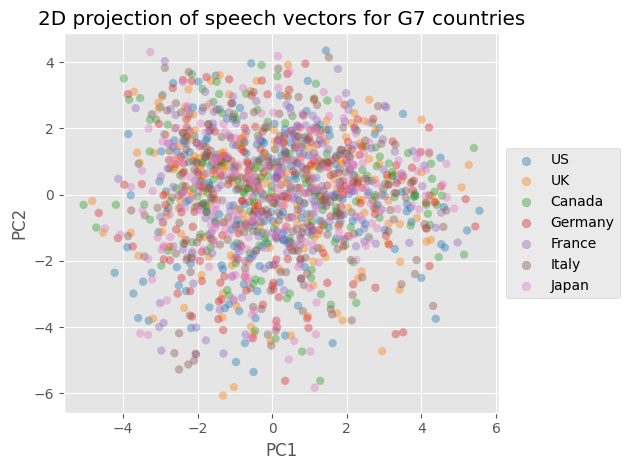

In [139]:
plt.style.use('ggplot')

scatter = sns.scatterplot(data = plot_df, x = 'PC1', y= 'PC2',
               hue = [z[0] for z in plot_df.index], alpha = 0.4, linewidth=0,
               palette = sns.color_palette("tab10", n_colors = len(G7) ))

scatter.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

for handle in scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1).legend_handles:
    handle.set_alpha(0.4)
    
    plt.title("2D projection of speech vectors for G7 countries")

#plt.xlim(-2, 1)

plt.tight_layout();
plt.savefig("CB_speeches/PCA.png")

t-SNE is no better. It's very hard to distinguish between countries in the plot.

In [118]:
from sklearn.manifold import TSNE

TS_model = TSNE(n_components=2, perplexity = 50)
TS_out = TS_model.fit_transform(np.array(x_df))

C:\Users\rtrva\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\rtrva\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [119]:
G7_xy = pd.DataFrame(TS_out)
G7_xy.columns = ['x', 'y']
G7_xy.index = x_df.index

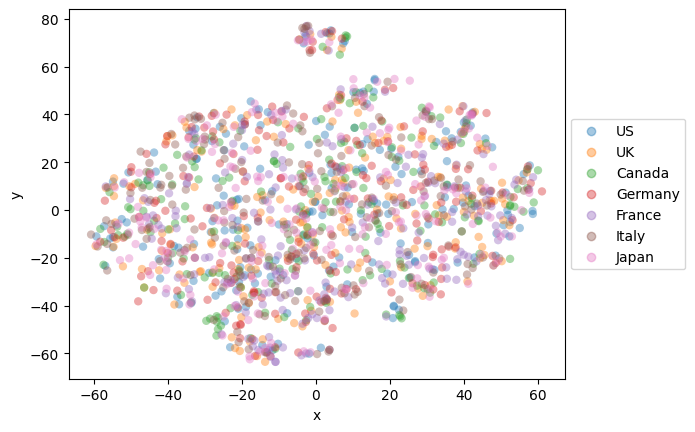

In [120]:
scatter = sns.scatterplot(data = G7_xy.iloc[samp_df, :], x = 'x', y= 'y',
               hue = [x[0] for x in G7_xy.iloc[samp_df, :].index], alpha = 0.4, linewidth=0,
               palette = sns.color_palette("tab10", n_colors=len(G7)))

scatter.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

for handle in scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1).legend_handles:
    handle.set_alpha(0.4)

### Conclusions

- Central bankers say similar things when there is some sort of urgent global crisis or event (such as the outbreak of COVID-19). This is not surprising at all, because they are all talking about the crisis.
- There was no obvious tendency for central bankers to either say the same things as each other or different things during a recession versus non-recession.
- Central bank speeches were least similar during the period of low real rates around 2011-2020, probably because policies were not implemented at the same time in different places (e.g. the EU was reluctant to perform QE while the US started it quite early).
- Central bankers in different countries say remarkably similar things. There is a lot more variation over time than between countries.